# Ar$\chi$iv database metadata analysis

## Introduction

This piece of work looks at metadata of Ar$\chi$iv academic papers database available, with the aim to perform exploratory data analysis based on on five columns: paper id, title, comments, journal reference and categories. Secondary aim is to develop a journal recommender system based on a title keyword through a collaborative filtering technique. 

The work follows a big data workflow. It starts with providing contextual information on the dataset. This is embeded into the "Acquisition" section. "Storage" paragraph gives information on where the data is kept currently, and possible location & tools to use for processing in the future. The "Analysis" section covers data wrangling, descriptive and diagnostic analysis. This is followed by the "Action" part of the project, which shws implementation of the recommender engine.


## I ) Acquisition

The data for this analysis has been obtained from Kaggle [1]. The dataset was downloaded and stored locally. Kaggle provides access to the metadata as well as links to the full Ar$\chi$ve database.

### Full database
Ar$\chi$iv is an open-access database that began operating in August 1991. As at 14th May 2022, they host 2,064,794 articles and academic e-prints from an array of quantitative fields, primarily physics, astophysics, mathematics, and computer science (as the analysis in this paper indicates also.) [2] The majority of e-prints are submitted to arXiv.org prior to publication, there is a smaller portion of papers added post appearance in a peer reviewed journal. The documents may be uploaded in formats such as LaTeX, PDF and postscript, and metadata provided for each [3]



### Metadata
The metadata is information that authors add to the documents on uplad to ar$\chi$iv, which assists with paper identification and classification. The full list of metadata fields is as follows [4]:

* Title: required
* Authors: required
* Abstract: required
* Comments: optional, but recommended
* Report-no: required (when supplied by author's institution)
* Category: depends on archive
* Journal-ref: reserved for publication info
* DOI: reserved publication DOI
* MSC-class: math archives only
* ACM-class: cs archives only

Each of the fields should be populated in a pre-defined format - as recommended by the ar$\chi$iv help pages [5], e.g. all authors need including, authors separated with commas, at least one category added per publication et cetera. Queries to the main database can be made through using metadata detail either by human or API users.
The current (14th May 2022) size of the metadata file is 3.15 GB.


### Metadata - JSON file
Metadata is provided via Kaggle in a form of a JSON (JavaScript Object Notation) file. JSON stores information as strings encoding dictionary-like objects. The dictionaries are represented with braces ( {} ), with name-value pairs separated by a comma ( , ), and the name and value per pair separated by a colon ( : ). The format is widely used for transmition of large-scale data due to being easily readible and lightweight [6] Upon loading the file onto the local machine, each line of the JSON file needs to be parsed separately and converted into a string of code understandable to a Python compiler. A brief investigation of the JSON file uncovered the entries were ordered by date added to the ar$\chi$ve repository.

## II ) Storage

After downloading the metadata, I stored it in the local C:// users file. In a real-life big data application, e.g. in a work context, I would use the on-premise server - as this is the technology available to my organisation now. The organisation are intending to move onto Azure Cloud services in the next couple of years, and I would look to utilise Azure once made available.

Other popular free open-sourse frameworks used in the industry for processing big data are Hadoop (Java based) and MangoDB (NoSQL.) These offer advantages such as:

- distributed file system
- storage capacity for structured and unstructured data
- map reduce functionality

However both solutions require advanced analyst / data scientist skillset which may be a barrier to use [7]

## III ) Analysis

The analysis section of this work is structured around Python code used for the project, and follows a typical analytical workflow for data mining projects. 

## III.a ) Data Warangling

Before implementing the analysis, data wrangling is performed to get an understanding of the information held.

### Load libraries & dataset

The load of the needed libraries and the arXiv metadata dataset from Kaggle.

In [1]:
# Load libraries
import pandas as pd
import json
from wordcloud import ImageColorGenerator, WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
import warnings

warnings.filterwarnings("ignore")

When coding for this project, the initally ingested sample consisted of a pre-determined number of JSON dictionary-like objects (one object per line) to enable quick processing for easy testing of scripts. This sample was not random, as it was based on a set number of objects from the beginning of the ordered database file. In the final run of the code, post quality assurance, the sections pertaining to generation of a limited non-random sample were commented out.

In [2]:
# read in the json file
data  = []
line_count = 0
#specify columns for loading
selected_cols = ["id", "title", "comments", "journal-ref", "categories"]
out={}
with open("arxiv-metadata-oai-snapshot.json", 'r') as f:
    for line in f:
        line_count += 1  
        out = {x: json.loads(line)[x] for x in selected_cols} 
        data.append(out)
        #if line_count==1000:
        #    break
data_ = pd.DataFrame(data)

Initial preparation of the data in line with the guidelines.

In [3]:
# drop rows where there are no comments in the comments column
data_.dropna(subset=['comments'], inplace=True)

In [4]:
# drop rows where there is "COVID" in the title column
#store data as CSV

mask = data_["title"].str.contains('covid', case=False) 
data_ = data_.loc[~mask]
data_.to_csv("data_full.csv",index=False)

### View and describe data (preliminary)

The view and describe - preliminary data overview - follows a series of steps as below:

- print sample of the data (view the head and tail of the dataset)
- check for missing values
- look at unique values for the columns for further investigation (journal_ref, categories)
- verify the size of the data (via describe method)
- check for outliers (via frequency tables and graphs)
- investigate data distributions (via frequency tables and graphs)

The aim is to understand the information and prepare it for further analysis.

In [5]:
data_.head()

,id,title,comments,journal-ref,categories
0,0704.0001,Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",hep-ph
1,0704.0002,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,math.CO cs.CG
2,0704.0003,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,physics.gen-ph
3,0704.0004,A determinant of Stirling cycle numbers counts...,11 pages,None,math.CO
5,0704.0006,Bosonic characters of atomic Cooper pairs acro...,"6 pages, 4 figures, accepted by PRA",None,cond-mat.mes-hall


In [6]:
data_.tail()

,id,title,comments,journal-ref,categories
2061362,supr-con/9608008,On the origin of the irreversibility line in t...,"19 pages, LaTex, 6 PostScript figures; Author'...",None,supr-con cond-mat.supr-con
2061363,supr-con/9609001,Nonlinear Response of HTSC Thin Film Microwave...,"4 pages, LaTeX type, Uses IEEE style files, 60...",None,supr-con cond-mat.supr-con
2061364,supr-con/9609002,Critical State Flux Penetration and Linear Mic...,"20 pages, LaTeX type, Uses REVTeX style files,...",None,supr-con cond-mat.supr-con
2061365,supr-con/9609003,Density of States and NMR Relaxation Rate in A...,"7 pages, 4 PostScript Figures, LaTeX, to appea...",None,supr-con cond-mat.supr-con
2061366,supr-con/9609004,Ginzburg Landau theory for d-wave pairing and ...,"12 pages including 8 eps figs, LaTeX with jpsj...","J. Phys. Soc. Jpn. 66, 204 (1997).",supr-con cond-mat.supr-con


In [7]:
data_.isna().sum()

id                  0
title               0
comments            0
journal-ref    948398
categories          0
dtype: int64

Further on, the describe function shows pertinet information about the dataset - as per the excerpt from the documentation files: "For object data (e.g. strings or timestamps), the result’s index will include count, unique, top, and freq. The top is the most common value. The freq is the most common value’s frequency. Timestamps also include the first and last items. If multiple object values have the highest count, then the count and top results will be arbitrarily chosen from among those with the highest count." [9]

In [8]:
data_.describe()

,id,title,comments,journal-ref,categories
count,1598729,1598729,1598729,650331,1598729
unique,1598725,1595501,990876,646440,58525
top,math-ph/0207039,Discussion of: A statistical analysis of multi...,10 pages,"Dans Design, Automation and Test in Europe - D...",astro-ph
freq,2,12,7131,127,85700


Observations: 
1) Journal-ref (JR) contains many missing values. It is the only variable with missing entries.

2) JR is a messy string, there's no clear format followed by each entry

3) JR carries journal name, volume, year and additional information re: journal

4) Categories - multiple categories per row, separated by space delimiter

5) ID - sequential. Upon reading up further documentation on the dataset [8], it is uncovered this follows a predetermined format where the first 4 digits represent year (YY) and month (MM) of arxiv upload.

6) ID and Title have primarily unique values, though there are repeated entries across both.

### ID, title and comments column analysis

The analysis underneath shows there are four repeated entries in the ID column, while the remaining values are unique. The repeated values combine journal category and id code in a format that differs to the standard format. These might have been genearted in error or added during the early days of the ar$\chi$iv existence. Similarly there are some repeated titles in the database - which likely correspond to the repeated ids or are otherwise genuinely differing papers which happen to share a title. In the comments section, the values most commonly entered are the lenght of paper (in pages.)

The strategy to deal with these is to remove rows with duplicate values in columns ID, while keeping duplicates in the title variable and comments. Due to the size of this data a loss of a few observations will not be significant for further analysis, nor devising of the recommender system.

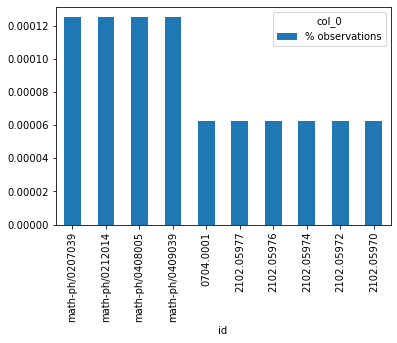

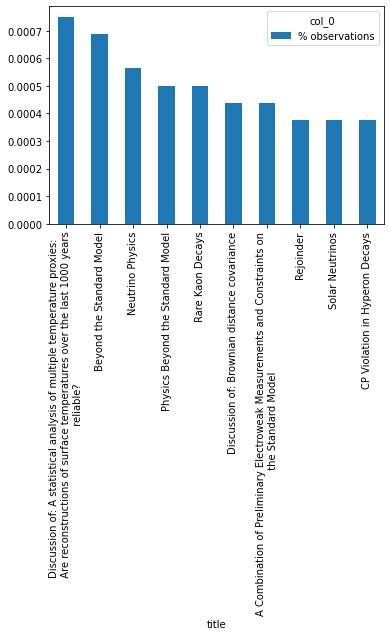

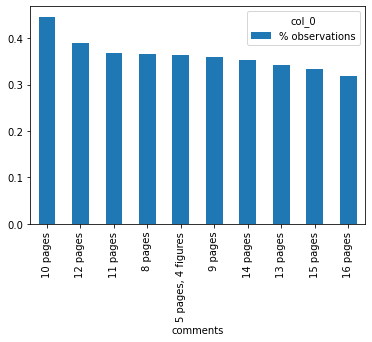

In [9]:
for column in data_[["id","title","comments"]].columns:
    freq_table = pd.DataFrame()
    freq_table = pd.crosstab(index=data_[column], columns='% observations', normalize='columns')*100
    freq_table_sorted = freq_table.sort_values(by="% observations",ascending=False)[:10]
    #display(freq_table)
    freq_table_sorted.plot(kind="bar")


### Journal reference column analysis

Prior to this step "journal-ref" missing values are filled with "Not specified" as otherwise these will not appear in the bar chart, yet they represent a significant portion of data. Post analysis it transpires there is a very significant number of records where journal name is not specified (approx.60%), which would affect final result of the recommender. These will not be needed for further analysis (since the task is to recommend specifically a journal per keyword in title.) Therefore these records will be dropped in the data cleaning section. Another observation is that outside the repeated "Not Specified" entries, other journal references are unique, yet there is a discernable "stem" for each. This is a pattern of characters conveying journal title which could to be extracted to better infer relationships with other variables. In the data cleaning section steps are undertaken to achieve this.

In [10]:
data_.fillna(value="Not Specified", axis=1, inplace=True)

col_0,% observations
journal-ref,
Not Specified,59.321999
"Dans Design, Automation and Test in Europe - DATE'05, Munich :\n Allemagne (2005)",0.007944
"Dans Symposium on Design, Test, Integration and Packaging of\n MEMS/MOEMS - DTIP 2008, Nice : France (2008)",0.004816
Prog Theor Exp Phys (2020),0.004629
"Dans Symposium on Design, Test, Integration and Packaging of\n MEMS/MOEMS - DTIP 2007, Stresa, lago Maggiore : Italie (2007)",0.004128
Prog Theor Exp Phys (2019),0.003315
Prog Theor Exp Phys (2018),0.003315
Prog Theor Exp Phys (2017),0.003253
"Dans Symposium on Design, Test, Integration and Packaging of\n MEMS/MOEMS - DTIP 2006, Stresa, Lago Maggiore : Italie (2006)",0.003065


<AxesSubplot:xlabel='journal-ref'>

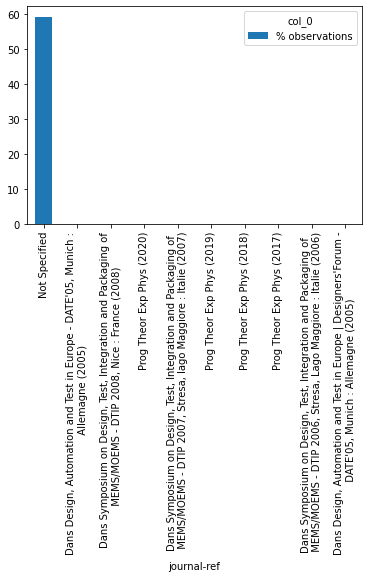

In [11]:
freq_table_JR = pd.DataFrame()
freq_table_JR = pd.crosstab(index=data_["journal-ref"], columns='% observations', normalize='columns')*100
display(freq_table_JR.sort_values(by="% observations",ascending=False)[:10])
freq_table_JR.sort_values(by="% observations",ascending=False)[:10].plot(kind="bar")

### Categories column analysis

The categories is looked at in a similar fashion as above. Although some entries are more represented than others, the table is not truly reflective of each category's frequency - due to split by space delimiter not yet being applied to the column. Yet still, there is already observable prevalence of some categories over others - with Astrophysics (astro-ph) being most represented, followed by High Energy Physics (hep-ph) and High Energy Physics - Theory (hep-th) [10]
Further processing will be inclusive of splitting the categories column by space delimiter.

col_0,% observations
categories,
astro-ph,5.360508
hep-ph,4.650632
hep-th,3.382875
quant-ph,3.107906
gr-qc,1.597081
cond-mat.mes-hall,1.534031
astro-ph.GA,1.502444
astro-ph.SR,1.438768
cs.CV,1.431762


<AxesSubplot:xlabel='categories'>

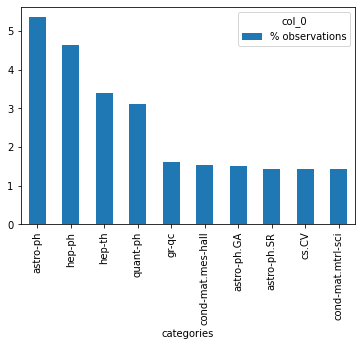

In [12]:
freq_table_C = pd.DataFrame()
freq_table_C = pd.crosstab(index=data_["categories"], columns='% observations', normalize='columns')*100
display(freq_table_C.sort_values(by="% observations",ascending=False)[:10])
freq_table_C.sort_values(by="% observations",ascending=False)[:10].plot(kind="bar")

## III.b) Data cleaning

The data cleaning process for this dataset includes:

- drop records with not specified journal reference
- drop records with duplicate ids
- drop "comments" as this is not needed for further analysis
- Extraction of "journal stem" - this is the journal name, excluding the numerical info on journal volume and edition
- Extraction of "journal year" - this is the journal year extracted from the journal-ref string using regex
- Split categories by space, create new column per additional category
- Restructure table from wide to long - creating multiple records per paper, so all categories sit in one column

Whenever string structure is processed care is taken to remove white trailing and leading white spaces.


In [13]:
data_.drop(data_[data_['journal-ref']=="Not Specified"].index, axis=0, inplace=True)
data_.drop_duplicates(subset= ["id"], inplace=True)
data_.drop(["comments"], axis=1, inplace=True)

In [14]:
#establishing a regex pattern to enable identification of year - for papers published since 2020
year_pattern = r'([2][0][0-2]{1}[0-9]{1})'

In [15]:
#extract journal year from journal reference
#first clean the string of trailing and preceeding white spaces
data_["journal-ref"] = data_["journal-ref"].str.strip()
data_["journal_year"] = data_["journal-ref"].str.extract(year_pattern, expand=True)
#extract journal name & remove spaces
# regex '(^\D+)' specifies non-numeric characters

journal_stem = data_["journal-ref"].str.extract(r'(^\D+)', expand=True)
journal_stem = journal_stem[0].str.replace(" ","")
data_["journal_stem"] = journal_stem

In [16]:
data_["journal_stem"] = data_["journal_stem"].str.replace("Vol","", case=False)
data_["journal_stem"] = data_["journal_stem"].str.replace("(","")
data_["journal_stem"] = data_["journal_stem"].str.replace(")","")
data_["journal_stem"] = data_["journal_stem"].str.replace(",","")
data_["journal_stem"] = data_["journal_stem"].str.replace(".","")
data_["journal_stem"] = data_["journal_stem"].str.replace(":","")
data_["journal_stem"] = data_["journal_stem"].str.replace('"',"")
data_["journal_stem"] = data_["journal_stem"].str.strip()

Check the extracted year values. Clear rows with values greater than current year or values missing, as these were clearly produced in error.

In [17]:
data_["journal_year"].unique()

array(['2007', '2008', '2005', '2006', '2009', '2001', '2010', '2004',
       '2012', '2011', '2002', nan, '2013', '2027', '2003', '2000',
       '2016', '2029', '2015', '2014', '2018', '2017', '2020', '2025',
       '2021', '2019', '2024', '2023', '2026', '2022', '2028'],
      dtype=object)

In [18]:
data_.dropna(subset=["journal_year"], inplace=True)
data_["journal_year"] = data_["journal_year"].astype(str).astype(int)
data_.drop(data_[data_["journal_year"]>2022].index, axis=0, inplace=True)
data_["journal_year"].unique()

array([2007, 2008, 2005, 2006, 2009, 2001, 2010, 2004, 2012, 2011, 2002,
       2013, 2003, 2000, 2016, 2015, 2014, 2018, 2017, 2020, 2021, 2019,
       2022])

Extraction of all categories (currently in one column, separated by space) and "melting" into a single column for further analysis.

In [19]:
delimiter=" "
categories = data_['categories'].str.split(delimiter, expand=True)
for column in categories.columns:
    categories[column].str.strip()
    name = "*cat " + str(column)
    data_[name] = categories[column]
data_.head()

,id,title,journal-ref,categories,journal_year,journal_stem,*cat 0,*cat 1,*cat 2,*cat 3,*cat 4,*cat 5,*cat 6,*cat 7,*cat 8,*cat 9,*cat 10,*cat 11,*cat 12
0,0704.0001,Calculation of prompt diphoton production cros...,"Phys.Rev.D76:013009,2007",hep-ph,2007,PhysRevD,hep-ph,None,None,None,None,None,None,None,None,None,None,None,None
6,0704.0007,Polymer Quantum Mechanics and its Continuum Limit,"Phys.Rev.D76:044016,2007",gr-qc,2007,PhysRevD,gr-qc,None,None,None,None,None,None,None,None,None,None,None,None
7,0704.0008,Numerical solution of shock and ramp compressi...,"Journal of Applied Physics, vol 104, 073536 (2...",cond-mat.mtrl-sci,2008,JournalofAppliedPhysics,cond-mat.mtrl-sci,None,None,None,None,None,None,None,None,None,None,None,None
14,0704.0015,Fermionic superstring loop amplitudes in the p...,"JHEP 0705:034,2007",hep-th,2007,JHEP,hep-th,None,None,None,None,None,None,None,None,None,None,None,None
15,0704.0016,Lifetime of doubly charmed baryons,"Commun.Theor.Phys.49:993-1000,2008",hep-ph,2008,CommunTheorPhys,hep-ph,None,None,None,None,None,None,None,None,None,None,None,None


Further on, the original columns for journal reference and categories are removed. 

In [20]:
data_.drop(["journal-ref","categories"], inplace=True, axis=1)
data_primary_category_only = data_[['id', 'title', 'journal_year', 'journal_stem', '*cat 0']].copy(deep=True)
data_long = pd.wide_to_long(data_, i=["id","title","journal_stem"], stubnames="*cat ", j="CAT").droplevel(-1).reset_index()
data_long.drop_duplicates(inplace=True)
data_long.dropna(subset = ['*cat '], inplace=True)

At the end of pre-processing, there are three dataframes being considered:
    
- *data_* : with all categories as additional columns
- *data_primary_category_only* : with only primary category as additional column
- *data_long* : with all categories as one additional column

## III.b ) Descriptive analysis

### View and describe data (post-processing)

This section focuses on visualising the data post-processing to give a better idea of new variable distributions (frequency of each occurence) - especially for the journal stem and category columns. 

Variable ID with unique values only shows a uniform distribution with frequency equal to 1/N per observation (where N is the lenght of the dataset.) Journal stem variable shows prevalence of titles as per the "Variable journal_stem distribution. Top 10 entries" bar graph below. Similarly there are now more prominent trends in terms of primary categories as demonstrated by the "Variable \*cat_0 distribution. Top 10 entries."

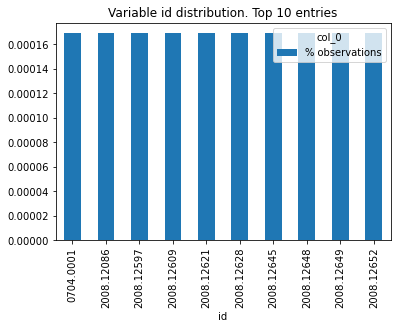

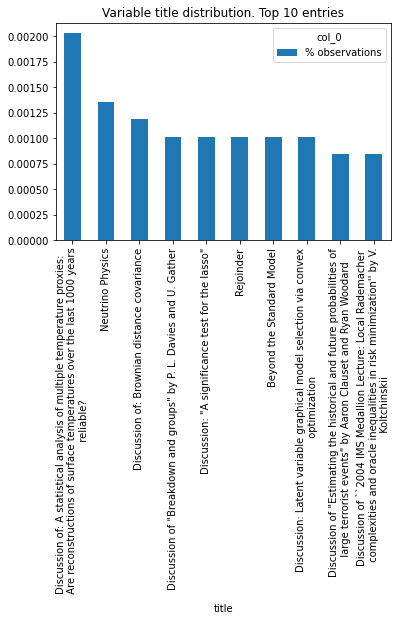

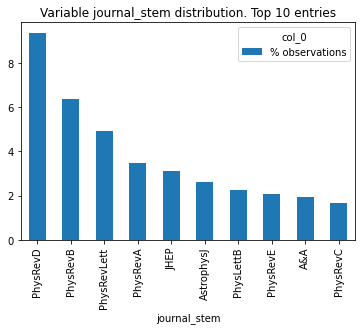

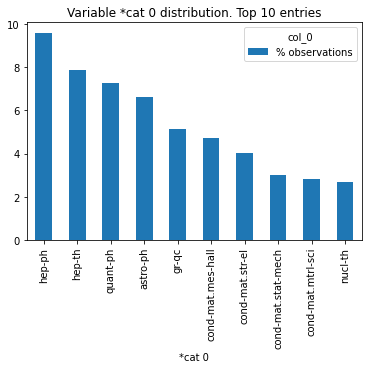

In [21]:
# Frequency tables for each categorical feature
# in this instance only focussing on 

for column in data_primary_category_only.select_dtypes(include=['object']).columns:
    freq_table = pd.DataFrame()
    freq_table = pd.crosstab(index=data_primary_category_only[column], columns='% observations', normalize='columns')*100
    #display(freq_table.sort_values(by="% observations",ascending=False)[:10])
    title ="Variable "+column+" distribution. Top 10 entries"
    freq_table.sort_values(by="% observations",ascending=False)[:10].plot(kind="bar", title = title)

The number of papers that get published to ar$\chi$iv after being added to journals is showing an increasing trend between 2000-2020 overall, with small dips in 2007, 2012 and 2021. The year information was extracted from the journal title, therefore it corresponds to the journal publication date - and not to the paper upload date to ar$\chi$iv which could be infered from the ID. Care needs to be taken when interpreting this timeseries, as some year values extracted may not be accurate. It is therefore an approximation - though keeping in line with the increasing trend in submissions reported by ar$\chi$iv themselves [11]

<AxesSubplot:xlabel='journal_year'>

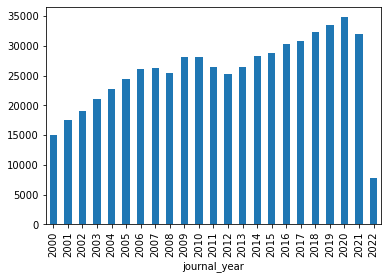

In [22]:
#distribution of papers by year - overall
data_primary_category_only.groupby(["journal_year"])["id"].nunique().plot(kind="bar")

The below section shows the frequency table and bar graphs for categories - across all categories allocated per each paper. Although the exact % of observations changed, the three main categories are the same as per the analysis based on the primary category only. Importantly though, these have changed from the categories that shown the highest prevalence when looking at the amalgamated "categories" variable in the initially loaded dataset.

col_0,% observations
*cat,
hep-ph,7.974531
hep-th,7.645502
quant-ph,5.995004
gr-qc,5.140502
astro-ph,4.588848
cond-mat.mes-hall,3.907586
cond-mat.str-el,3.658187
cond-mat.stat-mech,3.253099
cond-mat.mtrl-sci,2.780976


<AxesSubplot:xlabel='*cat '>

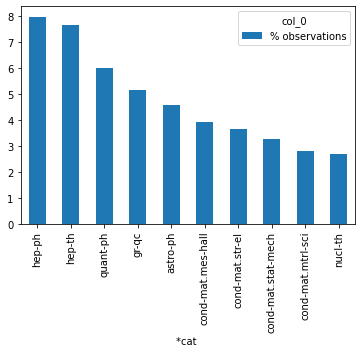

In [23]:
# frequency of category occurence (across all categories - primary and other)
all_cats_freq_table = pd.DataFrame()
all_cats_freq_table = pd.crosstab(index=data_long["*cat "], columns='% observations', normalize='columns')*100

all_cats_freq_table = all_cats_freq_table.sort_values(by="% observations",ascending=False)
display(all_cats_freq_table[:10])
all_cats_freq_table[:10].plot(kind="bar")

In [24]:
#select top 10 most popular categories
top10_cats = all_cats_freq_table.index[:10].tolist()
top10_cats_data_long  = data_long[data_long["*cat "].isin(top10_cats)]
top10_cats_data_long_grouped = top10_cats_data_long.groupby(["journal_year","*cat "])["journal_stem"].nunique().to_frame(name = 'count').reset_index()

Top 10 categories are identified and used to generate a line chart showing prevalence of journals with papers under different categories over the last 20+ years. 

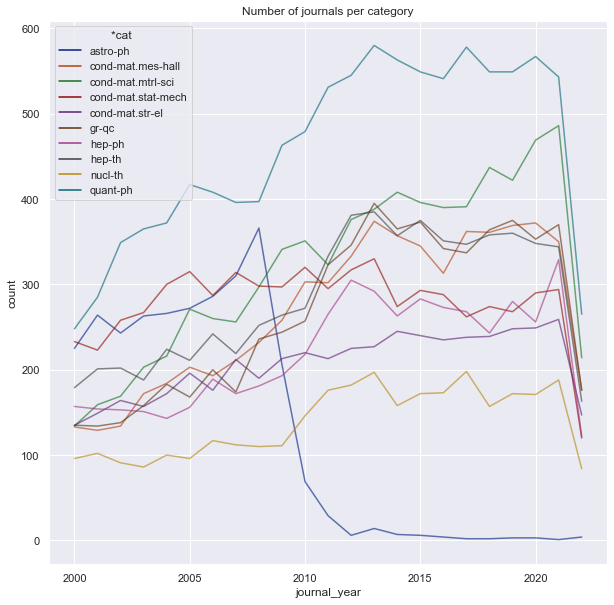

In [25]:
sns.set(rc={'figure.figsize':(10,10)})

g = sns.lineplot(
    data=top10_cats_data_long_grouped,
    x="journal_year", y="count", hue="*cat ",
    ci="sd", palette="dark", alpha=.6).set_title('Number of journals per category')



## III.c ) Diagnostic Analysis

This section investigates relationships between variables - in particular the relationship between category (primary and all) and journal. This is carried out through statistical hypothesis testing via $\chi^2$ method, as well as through production of correlation matrices between journal stem and category. A correlation matrix across categories based on journal entries is also produced.  

In [26]:
ContingencyTableAll = pd.crosstab(data_long["journal_stem"],data_long["*cat "])
ContingencyTableAll.head()

*cat,adap-org,alg-geom,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,chao-dyn,...,q-fin.TR,quant-ph,solv-int,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH,supr-con
journal_stem,,,,,,,,,,,,,,,,,,,,,
,0,0,7,14,4,6,5,12,18,0,...,1,7,0,2,0,1,5,0,1,0
#A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#JournalofPhysicsAMathematicalandGeneral,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
#MICAI,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#QuantumCommunicationComputingandMeasurementPlenum\nPublishingpp,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


### Check relationship via Chi-Square test (all categories)


H0: categories and journal-ref (stem) are independent

HA: categories and journal-ref (stem) are not independent

In [27]:
from scipy.stats import chi2_contingency

stat, p1, dof, expected = chi2_contingency(ContingencyTableAll)

In [28]:
# interpret p-value
prob = 0.95
alpha = 1.0 - prob
if p1 <= alpha:
	print('Categories and Journal Ref (Stem) are dependent (reject H0)')
else:
	print('Categories and Journal Ref (Stem) are independent (fail to reject H0)')

Categories and Journal Ref (Stem) are dependent (reject H0)


In [29]:
ContingencyTablePrimary = pd.crosstab(data_primary_category_only["journal_stem"],data_primary_category_only["*cat 0"])

### Check relationship via Chi-Square test (primary category)


H0: primary category and journal-ref (stem) are independent

HA: primary category and journal-ref (stem) are not independent

In [30]:
stat, p2, dof, expected = chi2_contingency(ContingencyTablePrimary)

In [31]:
# interpret p-value
prob = 0.95
alpha = 1.0 - prob
if p2 <= alpha:
	print('Categories and Journal Ref (Stem) are dependent (reject H0)')
else:
	print('Categories and Journal Ref (Stem) are independent (fail to reject H0)')

Categories and Journal Ref (Stem) are dependent (reject H0)


In [32]:
p2 > p1

False

There is more dissimilarity between primary category and journal stem than all paper categories and journal stem.
However, in both cases the variables are dependent - meaning there is a definite relationship between the two.

### Investigate relationship between categories based on journal classifications

Looking at categories that occur together in journals on the basis of applying the pandas corr method onto the contingency tables used to evualuate the hypotheses above. This assists in understanding the relationship between categories and answers the question of "Which categories are likely to be named for the same paper?" A list of most likely pairs is generated underneath.
Min_periods option is used for the corr matrix to eliminate spurious results. It is apparent that very high correlations occur between categories belonging to the same subject area (e.g. cond-mat.supr-con and cond-mat.str-el both cover condensed matter physics), which is an intuitive finding.

The matrix is the represented by a heatmap, however due to a large number of categories this is not entirely legible.

In [33]:
# correlation matrix to define minimum valid category mentions per journal, this helps eliminate spurious results
# generate a list of top 20 most correlated pairs
corr_matt_min_mentions = ContingencyTableAll.corr(method='pearson', min_periods=50)
corr_matt_min_mentions.unstack().sort_values(ascending=False).drop_duplicates()[:20]

*cat                *cat             
adap-org            adap-org             1.000000
cond-mat.supr-con   cond-mat.str-el      0.996790
cond-mat.mes-hall   cond-mat.str-el      0.994324
astro-ph.SR         astro-ph.GA          0.993405
cond-mat.mes-hall   cond-mat.supr-con    0.992824
astro-ph.EP         astro-ph.SR          0.991896
cs.LO               cs.FL                0.990197
cs.PL               cs.LO                0.990016
                    cs.FL                0.989703
cond-mat.quant-gas  quant-ph             0.987532
astro-ph.GA         astro-ph.EP          0.987091
cond-mat.mes-hall   cond-mat.mtrl-sci    0.986003
cond-mat.mtrl-sci   cond-mat.supr-con    0.980256
cond-mat.str-el     cond-mat.mtrl-sci    0.979234
physics.atom-ph     quant-ph             0.972372
cond-mat.quant-gas  physics.atom-ph      0.967209
hep-ph              hep-ex               0.965654
cond-mat.soft       physics.bio-ph       0.964940
nucl-ex             nucl-th              0.964663
cs.GT       

In [34]:
corr_matt_min_mentions.head()

*cat,adap-org,alg-geom,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,chao-dyn,...,q-fin.TR,quant-ph,solv-int,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH,supr-con
*cat,,,,,,,,,,,,,,,,,,,,,
adap-org,1.000000,-0.000418,0.017187,0.022407,0.007691,0.006365,0.028771,0.017666,0.009936,0.559343,...,0.476060,0.267747,0.049087,0.020806,0.080508,0.018530,0.119098,0.167885,0.010048,-0.000104
alg-geom,-0.000418,1.000000,-0.000183,-0.000234,-0.000124,-0.000216,-0.000345,-0.000466,-0.000229,-0.000378,...,-0.000435,0.001852,0.079671,-0.000233,-0.000906,-0.000405,-0.001103,-0.000529,0.000132,-0.000090
astro-ph,0.017187,-0.000183,1.000000,0.463242,0.131484,0.193383,0.459671,0.224054,0.174969,0.048759,...,0.010136,0.051409,0.024611,0.006832,0.034018,0.004945,0.041828,0.008480,0.000654,-0.000066
astro-ph.CO,0.022407,-0.000234,0.463242,1.000000,0.232414,0.325299,0.903556,0.548188,0.282854,0.082524,...,0.010775,0.115292,0.020953,0.010212,0.060552,0.006109,0.104665,0.010731,0.000796,-0.000066
astro-ph.EP,0.007691,-0.000124,0.131484,0.232414,1.000000,0.987091,0.560115,0.887770,0.991896,0.016614,...,0.005710,0.010208,0.001461,0.017407,0.040069,0.005827,0.021856,0.004908,0.001590,-0.000064


<AxesSubplot:xlabel='*cat ', ylabel='*cat '>

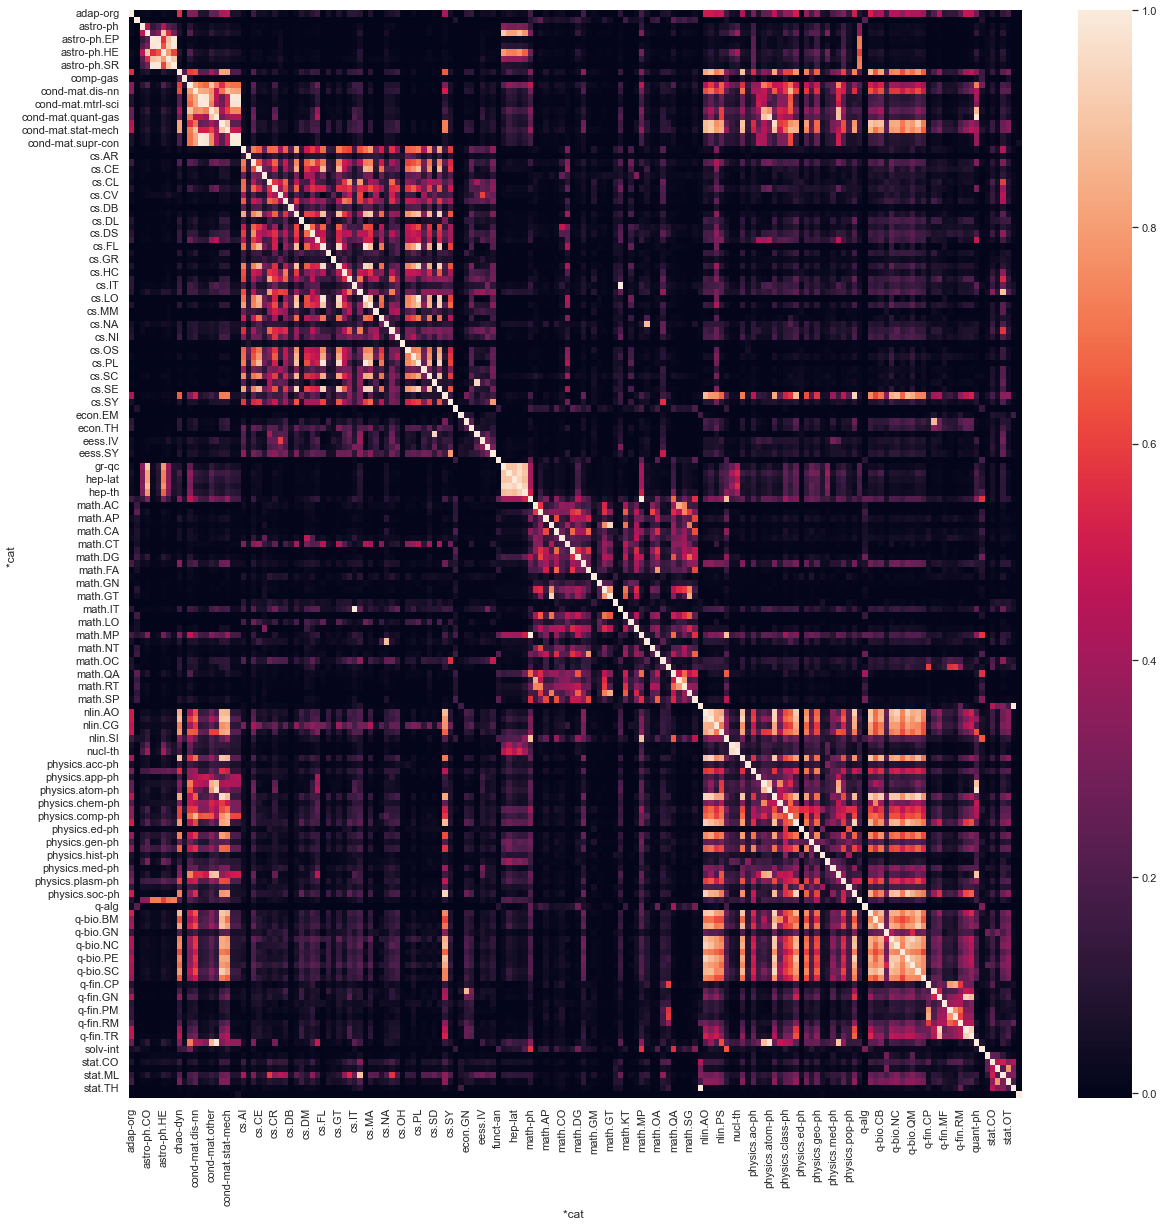

In [35]:
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matt_min_mentions)

## IV. Action

### Recommender system

The action step describes the process of building a recommender system that suggests a journal title given a keyword. For this purpose the top 10 most frequent words across all tiles need to be first determined. The wordcloud library is used for this due to its ability to visualise the data, as well as facilitating removal of predetermined stopwords (common frequently used words such as "and", "or", "but" etc.) Wordcloud can also return a dictionary of word:frequency pairs which can be employed to easily identify the most popular words. There are other libraries capable of tokenising the master string and performing frequency counts (e.g. sklearn CountVectoriser or NLTK) however these would require additional package installation and would be superflous - considering the requirements of the task can be met by WordCloud.

To tokenise the titles, first a master string containing all title entries is generated. This is then passed into WordCloud and visualisation of the frequent words is performed. From this it is clear the most prominent entries are ... , though it is difficult to determine boynd the most popular three. Therefore a bar graph is generated. Subsequently each word from the top 10 is searched for in the data_long dataset title (containing all categories per paper). The table is filtered to focus on papers with the keyword in the title. The function then counts occurence of each journal category within the sample, and returns the most frequent.

In [36]:
#creates a string that aggregates all paper titles
all_titles_string = ""

for index, row in data_primary_category_only.iterrows():
    all_titles_string += row["title"]
    all_titles_string += " "

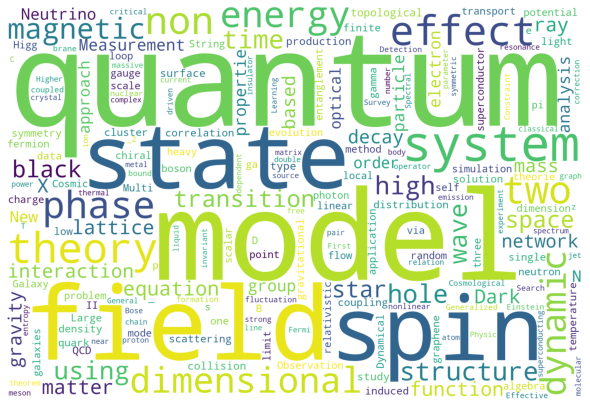

In [37]:
#generating a wordcloud

wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=2200,
                          height=1500
                         ).generate(all_titles_string)


plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
 
plt.show()

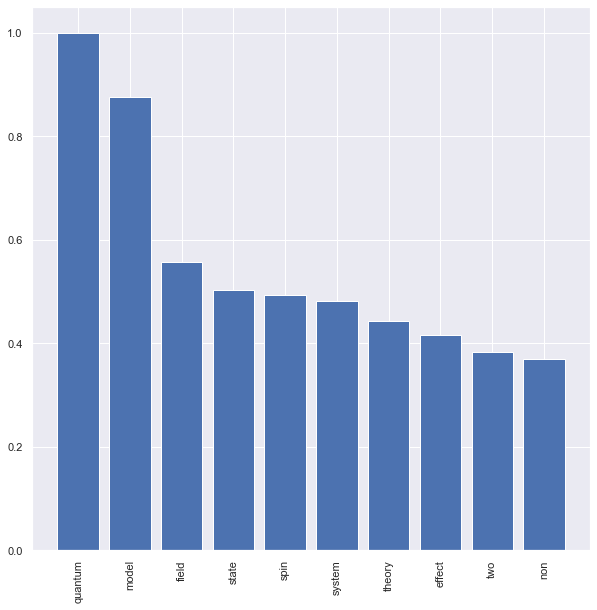

<Figure size 640x640 with 0 Axes>

In [38]:
#show frequency of words' occurence (standardised with reference to most frequent word)
N = 10
  
top_ten = dict(sorted(wordcloud.words_.items(), key = itemgetter(1), reverse = True)[:N])

plt.bar(top_ten.keys(), top_ten.values())
plt.xticks(rotation='vertical')
plt.figure(figsize=(8, 8), facecolor=None, dpi=80)
plt.show()

In [39]:
data_truncated = data_primary_category_only.drop(["id"], axis=1).copy(deep=True)
for keyword in top_ten.keys():
    print("Searching the database... \n")
    select_journals = data_truncated[data_truncated['title'].str.contains(keyword)].drop(["title"], axis=1).groupby(data_truncated['journal_stem']).count()["journal_stem"]
    journal = select_journals.sort_values(ascending=False).index[0]
    #journal_full = category_map[journal]
    print("The journal suggestion for the keyword: '", keyword, "' is ", journal, "\n")

Searching the database... 



The journal suggestion for the keyword: ' quantum ' is  PhysRevB 



Searching the database... 



The journal suggestion for the keyword: ' model ' is  PhysRevD 



Searching the database... 



The journal suggestion for the keyword: ' field ' is  PhysRevD 



Searching the database... 



The journal suggestion for the keyword: ' state ' is  PhysRevB 



Searching the database... 



The journal suggestion for the keyword: ' spin ' is  PhysRevB 



Searching the database... 



The journal suggestion for the keyword: ' system ' is  PhysRevB 



Searching the database... 



The journal suggestion for the keyword: ' theory ' is  PhysRevD 



Searching the database... 



The journal suggestion for the keyword: ' effect ' is  PhysRevB 



Searching the database... 



The journal suggestion for the keyword: ' two ' is  PhysRevB 



Searching the database... 



The journal suggestion for the keyword: ' non ' is  PhysRevB 




## Conclusions

This work aimed to deliver a thorough analysis of the metadata information of the ar$\chi$iv database - through conduncting data wrangling and cleaning, exploratory and diagnostic analysis and developing of a recommender system. The work found strong relationship across paper categories - for papers submitted to journals. There was also a significant correlation between journal titles and paper categories - which agrees with common notion that academic journals are subject-area specific. The developed recommender system suggested "PhysRevB" or "PhysRevC" journal title for all of the top ten words. This is in line with these two journals being most prominent in the dataset according to the frequency table and bar graph generated for the data after cleaning. To improve upon the recommender system, consideration should be given to data cleaning and stemming of the journal-ref string.

## References

[1] https://www.kaggle.com/datasets/Cornell-University/arxiv

[2] https://arxiv.org/#:~:text=arXiv%20is%20a%20free%20distribution,and%20systems%20science%2C%20and%20economics.

[3] https://arxiv.org/about

[4] https://arxiv.github.io/arxiv-arxitecture/context_and_scope.html

[5] https://arxiv.org/help/prep)

[6] https://www.w3schools.com/js/js_json_intro.asp

[7] https://www.simplilearn.com/hadoop-vs-mongodb-article#:~:text=MongoDB%20is%20a%20C%2B%2B%20based,optimizes%20space%20better%20than%20MongoDB.

[8] https://arxiv.org/help/arxiv_identifier

[9] https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html

[10] https://arxiv.org/category_taxonomy

[11] https://arxiv.org/help/stats/2021_by_area